<a href="https://colab.research.google.com/github/shreyasudaya/Viral-GNN/blob/test-dataset/gnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:

!pip install torch-geometric

In [45]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dtrans = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/image-net/fcgr'
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=dtrans['train'])
val_dataset = datasets.ImageFolder(root=f'{data_dir}/val', transform=dtrans['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Classes: {class_names}")


Classes: ['B.1.1.519', 'B.1.1.529', 'B.1.1.7', 'B.1.351', 'B.1.427', 'B.1.429', 'B.1.525', 'B.1.526', 'B.1.617.2', 'B.1.621', 'C.37', 'P.1']


In [46]:
import torch.nn as nn
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = models.resnet18(pretrained=True)

cnn_model = nn.Sequential(*list(cnn_model.children())[:-1])

cnn_model = cnn_model.to(device)

def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            features.append(outputs.squeeze().cpu())
            labels.append(targets.cpu())
    return torch.cat(features), torch.cat(labels)

# Extract features and ensure they are on CPU for further processing
train_features, train_labels = extract_features(cnn_model, train_loader)
val_features, val_labels = extract_features(cnn_model, val_loader)

train_features = train_features.to(device)
train_labels = train_labels.to(device)
val_features = val_features.to(device)
val_labels = val_labels.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
from sklearn.neighbors import NearestNeighbors
import torch_geometric

def build_graph(features, k=5):
    features_cpu = features.cpu()

    # Use NearestNeighbors to find k-nearest neighbors based on cosine similarity
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(features_cpu)
    adj = nbrs.kneighbors_graph(features_cpu).toarray()

    # Convert the adjacency matrix to a sparse edge index for GCN
    edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj))[0]

    return edge_index

train_edge_index = build_graph(train_features, k=5)
val_edge_index = build_graph(val_features, k=5)


In [48]:
import torch_geometric
from torch_geometric.nn import GCNConv

class VisionGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VisionGNN, self).__init__()
        # Two GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

in_channels = 512
hidden_channels = 256
out_channels = num_classes
gnn_model = VisionGNN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels)

gnn_model = gnn_model.to(device)

In [49]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)


def train_model(model, features, labels, edge_index, epochs=300):
    model.train()
    losses = []
    accuracies = []
    for epoch in range(epochs):
        optimizer.zero_grad()


        edge_index = edge_index.to(device)

        outputs = model(features, edge_index)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        losses.append(loss.item())
        accuracies.append(accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    return losses,accuracies
train_edge_index = train_edge_index.to(device)
losses,accuracies = train_model(gnn_model, train_features, train_labels, train_edge_index)

def evaluate_model(model, features, labels, edge_index):
    model.eval()
    with torch.no_grad():
        edge_index = edge_index.to(device)

        # Forward pass
        outputs = model(features, edge_index)
        _, preds = torch.max(outputs, 1)

        # Calculate accuracy
        accuracy = torch.sum(preds == labels).item() / len(labels)
    print(f'Validation Accuracy: {accuracy:.4f}')

val_edge_index = val_edge_index.to(device)
evaluate_model(gnn_model, val_features, val_labels, val_edge_index)


Epoch [1/300], Loss: 3.5339, Accuracy: 0.0036
Epoch [2/300], Loss: 2.8775, Accuracy: 0.1187
Epoch [3/300], Loss: 2.6037, Accuracy: 0.1118
Epoch [4/300], Loss: 2.4590, Accuracy: 0.1213
Epoch [5/300], Loss: 2.5066, Accuracy: 0.0892
Epoch [6/300], Loss: 2.5132, Accuracy: 0.1079
Epoch [7/300], Loss: 2.4153, Accuracy: 0.1079
Epoch [8/300], Loss: 2.3548, Accuracy: 0.2036
Epoch [9/300], Loss: 2.3510, Accuracy: 0.1409
Epoch [10/300], Loss: 2.3668, Accuracy: 0.1774
Epoch [11/300], Loss: 2.3816, Accuracy: 0.1217
Epoch [12/300], Loss: 2.3802, Accuracy: 0.1568
Epoch [13/300], Loss: 2.3578, Accuracy: 0.1145
Epoch [14/300], Loss: 2.3249, Accuracy: 0.1206
Epoch [15/300], Loss: 2.3026, Accuracy: 0.2593
Epoch [16/300], Loss: 2.3008, Accuracy: 0.2174
Epoch [17/300], Loss: 2.3074, Accuracy: 0.1688
Epoch [18/300], Loss: 2.3014, Accuracy: 0.1971
Epoch [19/300], Loss: 2.2845, Accuracy: 0.2275
Epoch [20/300], Loss: 2.2716, Accuracy: 0.3911
Epoch [21/300], Loss: 2.2691, Accuracy: 0.4767
Epoch [22/300], Loss: 

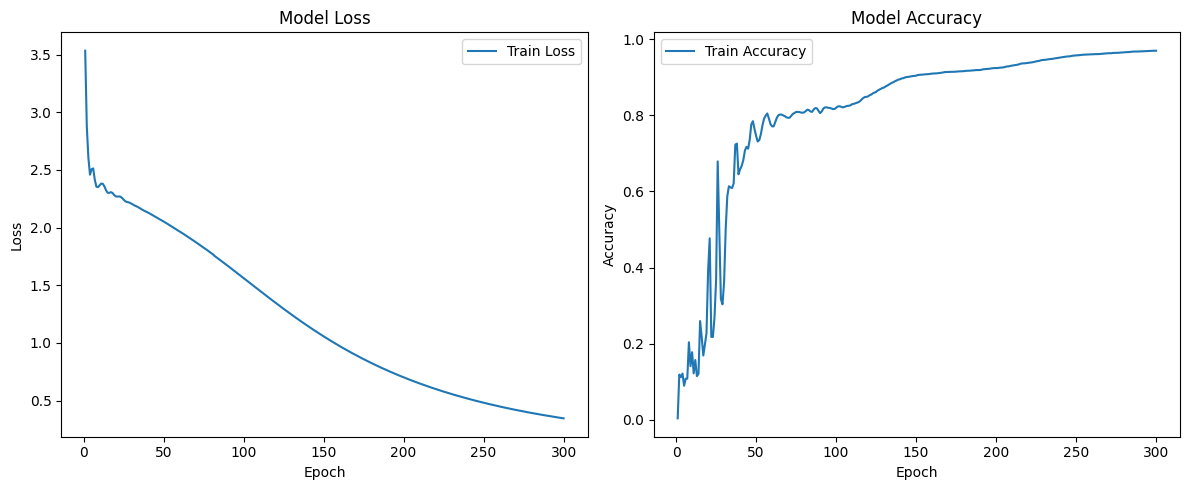

In [51]:
# Plot training and validation loss
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
